In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

In [16]:
data = pd.read_csv("data/training_data_ht2025.csv")

data['target'] = data['increase_stock'].apply(lambda x: 1 if x == "high_bike_demand" else 0)
data = data.drop(columns=['snow'])


X = data.drop(['increase_stock', 'target'], axis=1) # dropping target and helper columns
y = data['target']

# Split the data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1280, 14)
Testing shape: (320, 14)


In [17]:
y.value_counts(normalize=True) # high_bike_demand is the minority class!!

target
0    0.82
1    0.18
Name: proportion, dtype: float64

In [18]:
# hyperparameter tuning with cross-validation

rf = RandomForestClassifier(random_state=23, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [10, 15, 20, None],      # How deep each tree can grow
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']      # Number of features to consider at every split
}

In [19]:
# Stratified K-Fold so that each fold has the same proportion of classes

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=23) 

In [ ]:
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = cv_strategy,
     scoring = make_scorer(f1_score, pos_label=1), # focusing on F1 score for the minority class
    n_jobs = -1,
    verbose = 1
)

In [21]:
print("Grid Search starting...\n")
grid_search.fit(X_train, y_train)

Grid Search starting...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,RandomForestC...ndom_state=23)
,param_grid,"{'max_depth': [10, 15, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [22]:
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")


Best Parameters found: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9016


In [23]:
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_optimized))
print(classification_report(y_test, y_pred_optimized, target_names=['low_bike_demand', 'high_bike_demand']))

Accuracy: 0.875
                  precision    recall  f1-score   support

 low_bike_demand       0.93      0.91      0.92       262
high_bike_demand       0.64      0.71      0.67        58

        accuracy                           0.88       320
       macro avg       0.79      0.81      0.80       320
    weighted avg       0.88      0.88      0.88       320



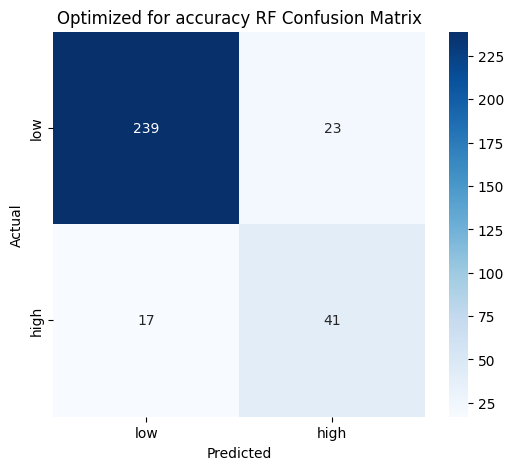

In [27]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_optimized), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'high'], yticklabels=['low', 'high'])
plt.title('Optimized for accuracy RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
y_test.value_counts(normalize=True)

target
0    0.81875
1    0.18125
Name: proportion, dtype: float64

In [26]:
# NAIVE CLASSIFIER FOR COMPARISON 
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)
print("Dummy Classifier Accuracy:", accuracy_score(y_test, y_dummy_pred))
print(classification_report(y_test, y_dummy_pred, target_names=['low_bike_demand', 'high_bike_demand']))


Dummy Classifier Accuracy: 0.81875
                  precision    recall  f1-score   support

 low_bike_demand       0.82      1.00      0.90       262
high_bike_demand       0.00      0.00      0.00        58

        accuracy                           0.82       320
       macro avg       0.41      0.50      0.45       320
    weighted avg       0.67      0.82      0.74       320



c:\Users\mkami\OneDrive\Pulpit\UNI\Statistical-Machine-Learning-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mkami\OneDrive\Pulpit\UNI\Statistical-Machine-Learning-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mkami\OneDrive\Pulpit\UNI\Statistical-Machine-Learning-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

# Classification reports for various models

## Random Forest with Grid Search optimized for F1 score
Accuracy: 0.871875
||precision    |recall  |f1-score  | 
|----------------|----------|---------|----------|
| low_bike_demand |      0.93|      0.91|      0.92|       
|high_bike_demand |      0.63|      0.69|      0.66|      

## Random Forest with Grid Search optimized for Accuracy
Accuracy: 0.875
||precision    |recall  |f1-score  | 
|----------------|----------|---------|----------|
| low_bike_demand |      0.93|      0.91|      0.92|       
|high_bike_demand |      0.64|      0.71|      0.67|      
## Random Forest Default
Accuracy: 0.884375
||precision    |recall  |f1-score  | 
|----------------|----------|---------|----------|
| low_bike_demand |      0.91|      0.95|      0.93|     
|high_bike_demand |      0.73|      0.57|      0.64|     

## One Default Decision Tree
Decision Tree Accuracy: 0.83125

||precision    |recall  |f1-score  | 
|----------------|----------|---------|----------|
| low_bike_demand|        0.89|      0.91|      0.90|    
|high_bike_demand|       0.54 |     0.47 |     0.50 |   

## Dummy Classifier (most frequent class)
Dummy Classifier Accuracy: 0.81875
||precision    |recall  |f1-score  | 
|----------------|----------|---------|----------|
| low_bike_demand |      0.82|      1.00|      0.90|     
|high_bike_demand |      0.00|      0.00|      0.00|     

While optimizing for F1 Score and Accuracy yielded similar results on this specific test set due to its small size, both tuned models significantly outperformed the default Random Forest in Recall (0.71 vs 0.57). This confirms that hyperparameter tuning successfully reduced the risk of missing high-demand days, which was the primary business objective.